# Paired simultaneous recording from soma and dendrite of the same neuron

#### **Basic instructions:**
#### 1. **To run code windows/blocks:** 

    - you can either hit the play button to the left of the code window 

    - or you can use they keyboard shortcut: select the block and press 'shift-enter'.

#### 2. **The first time** you run this code notebook, you might get a popup asking to choose which version of Python to use (the python "kernel"). **Just hit enter** to choose the base/default version.

#### 3. Make sure you data (.abf) files are in the "data" folder here on the left. You can just copy/paste the files from where they are saved on your computer.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from utils import *
update_plot_defaults()
%load_ext autoreload
%autoreload 2

## 1. Choose the data file you want to analyze

#### Put the .abf files with your Ih recordings in the "data/Dendrites" folder

In [2]:
data_folder = "data/14-free_day/paired soma-dendrite/"

import os
print("All data subfolders:")
for subdir in os.listdir(data_folder):
    if os.path.isdir(data_folder + "/" + subdir):
        print(f"'{data_folder}/{subdir}'")

# from glob import glob
# print("Files:")
# data_files = glob(data_folder+"/*.abf")
# data_files.sort()
# data_files

All data subfolders:
'data/14-free_day/paired soma-dendrite//soma current injection'
'data/14-free_day/paired soma-dendrite//dendritic injection'
'data/14-free_day/paired soma-dendrite//dual current injection'


### Choose (copy/paste) the correct data subfolder

In [3]:
# data_folder = "data/14-free_day/paired soma-dendrite/dual current injection"
# data_folder = "data/14-free_day/paired soma-dendrite/soma current injection"
data_folder = "data/14-free_day/paired soma-dendrite/dendritic injection"

import os
print("Folders:")
for subdir in os.listdir(data_folder):
    if os.path.isdir(data_folder + "/" + subdir):
        print(f"'{data_folder}/{subdir}'")

from glob import glob
print("Files:")
data_files = glob(data_folder+"/*.abf")
data_files.sort()
data_files

Folders:
Files:


['data/14-free_day/paired soma-dendrite/dendritic injection/2025_06_20_0014.abf',
 'data/14-free_day/paired soma-dendrite/dendritic injection/2025_06_20_0015.abf',
 'data/14-free_day/paired soma-dendrite/dendritic injection/2025_06_20_0017.abf',
 'data/14-free_day/paired soma-dendrite/dendritic injection/2025_06_20_0019.abf',
 'data/14-free_day/paired soma-dendrite/dendritic injection/2025_06_20_0020.abf',
 'data/14-free_day/paired soma-dendrite/dendritic injection/2025_06_20_0024.abf',
 'data/14-free_day/paired soma-dendrite/dendritic injection/2025_06_20_0025.abf',
 'data/14-free_day/paired soma-dendrite/dendritic injection/2025_06_20_0026.abf',
 'data/14-free_day/paired soma-dendrite/dendritic injection/2025_06_20_0027.abf',
 'data/14-free_day/paired soma-dendrite/dendritic injection/2025_06_20_0028.abf',
 'data/14-free_day/paired soma-dendrite/dendritic injection/2025_06_20_0029.abf']

Choose which file you want to analyze (copy name from above) and paste the file name here:

In [4]:
# data_file = 'data/14-free_day/paired soma-dendrite/soma current injection/2025_06_20_0013.abf'
# data_file = 'data/14-free_day/paired soma-dendrite/soma current injection/2025_06_20_0013.abf'
# data_file = 'data/14-free_day/paired soma-dendrite/dual current injection/2025_06_20_0001.abf'
data_file = 'data/14-free_day/paired soma-dendrite/dendritic injection/2025_06_20_0029.abf'


Now we can load the file and plot the raw data:

Trace('2025_06_20_0029.abf')
Number of headstages: 2
Number of sweeps: 1
Points per sweep: 12,000
Duration per sweep: 1.200 s
Sampling rate: 10000 Hz
Sampling interval: 0.100 ms
Available channels: Current, Voltage


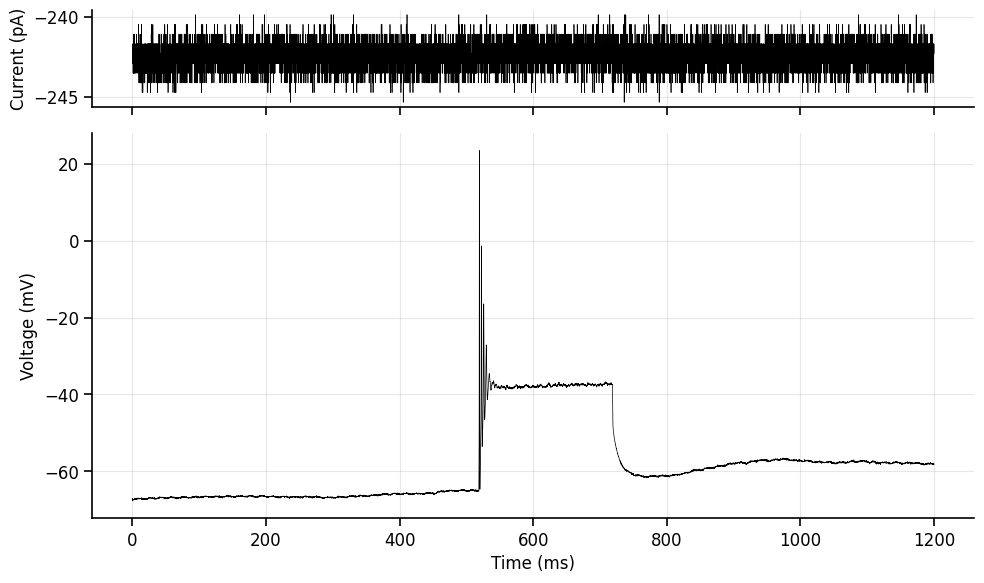

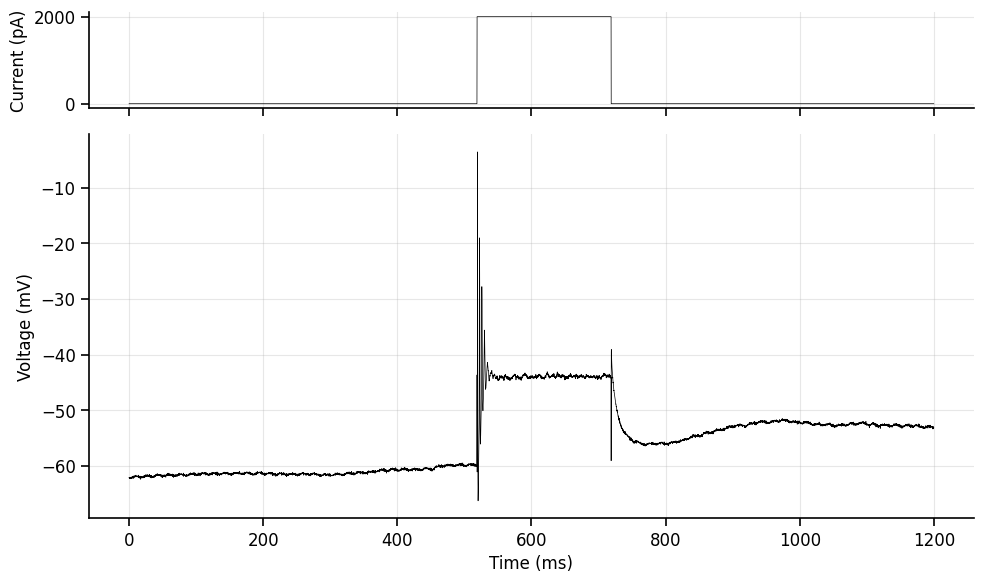

In [5]:
traces = Trace.from_axon_file_multi_headstage(data_file,
                                            headstage_channels=[(1, 0), (3, 2)],  # Current/voltage pairs
                                            concatenate_sweeps=False)

print(traces)

time_units = 'ms' # specify seconds (s), or milliseconds (ms)

# ----------------------------------------------------------------------------------------------------------------
%matplotlib inline
traces.plot_multi_headstage(headstage=0, plot_current=True, plot_voltage=True, height_ratios=[1, 4], time_units=time_units)
traces.plot_multi_headstage(headstage=1, plot_current=True, plot_voltage=True, height_ratios=[1, 4], time_units=time_units)
plt.show()

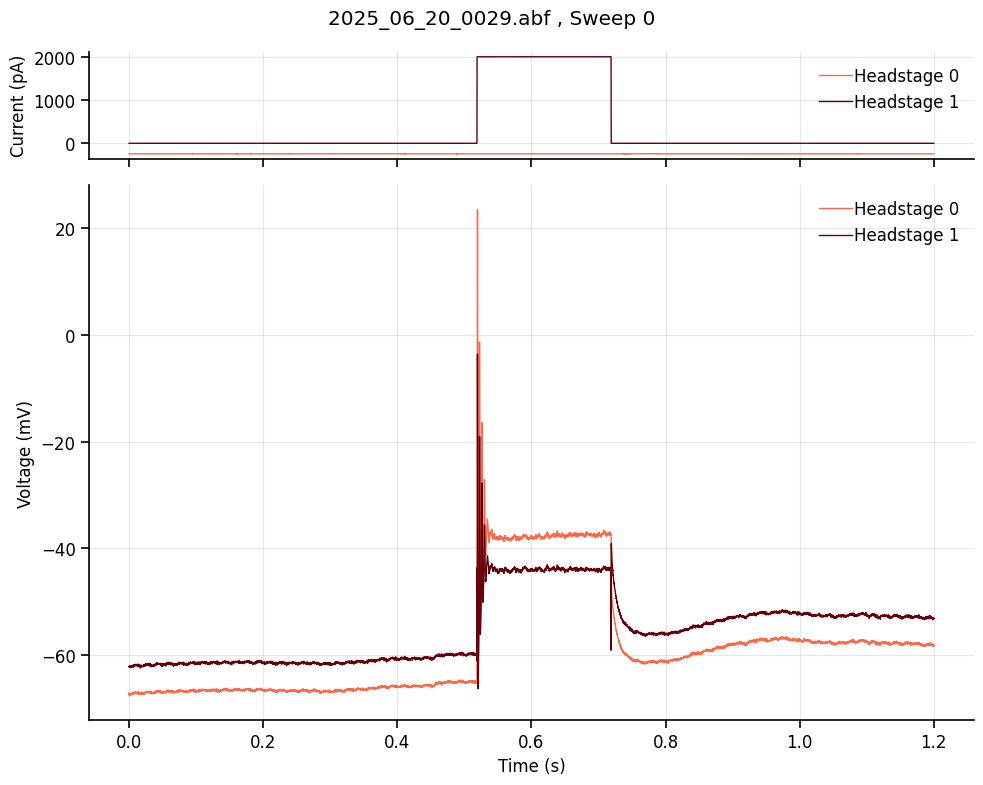

In [6]:
# Plot specific sweep with both headstages overlayed
sweep = 0
ax = traces.plot_multi_headstage(headstage=[0, 1], plot_current=True, plot_voltage=True, sweep=sweep, overlay_headstages=True, height_ratios=[1,5])
plt.show()

## 2. Signal processing

### Apply baseline correction

If your baseline current is not at zero, run the next code blocks to apply a baseline correction.

In [7]:
baseline_start = 0.4
baseline_end = 0.5

# Multi-headstage: correct specific headstage
traces.subtract_baseline(start_time=baseline_start, end_time=baseline_end, time_units=time_units, 
                        channel='all', headstage='all')

BASELINE SUBTRACTED:
Headstage 0 - Baseline currents: [-242.9199]
Headstage 0 - Baseline voltages: [-67.3584]
Headstage 1 - Baseline currents: [0.6104]
Headstage 1 - Baseline voltages: [-62.2253]


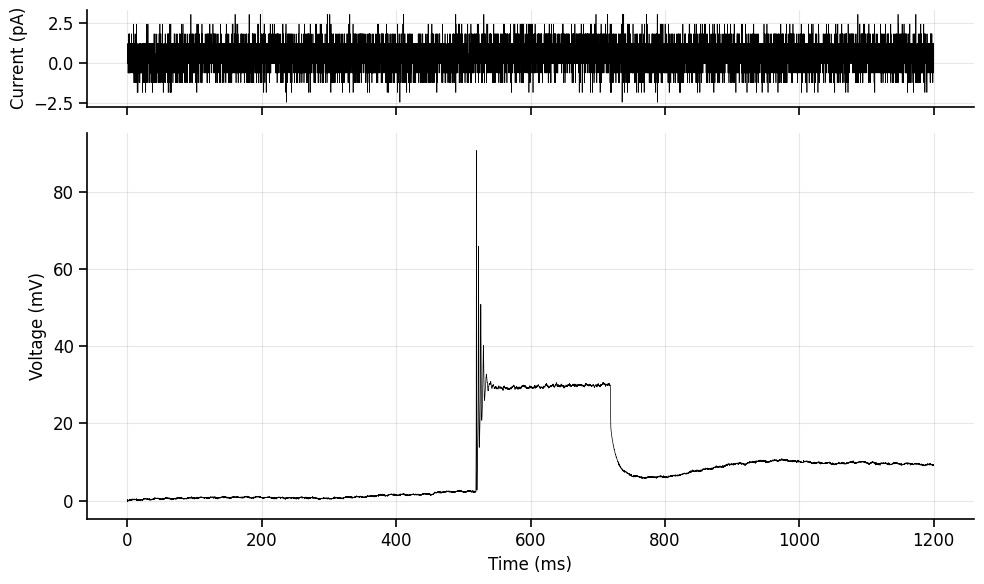

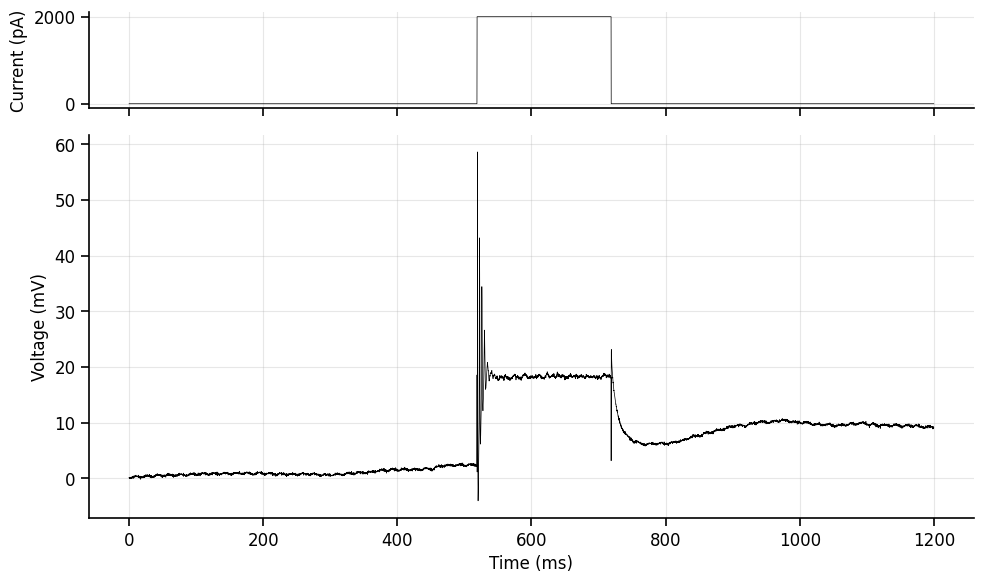

In [8]:
%matplotlib inline
traces.plot_multi_headstage(headstage=0, plot_current=True, plot_voltage=True, height_ratios=[1, 4], time_units=time_units)
traces.plot_multi_headstage(headstage=1, plot_current=True, plot_voltage=True, height_ratios=[1, 4], time_units=time_units)
plt.show()

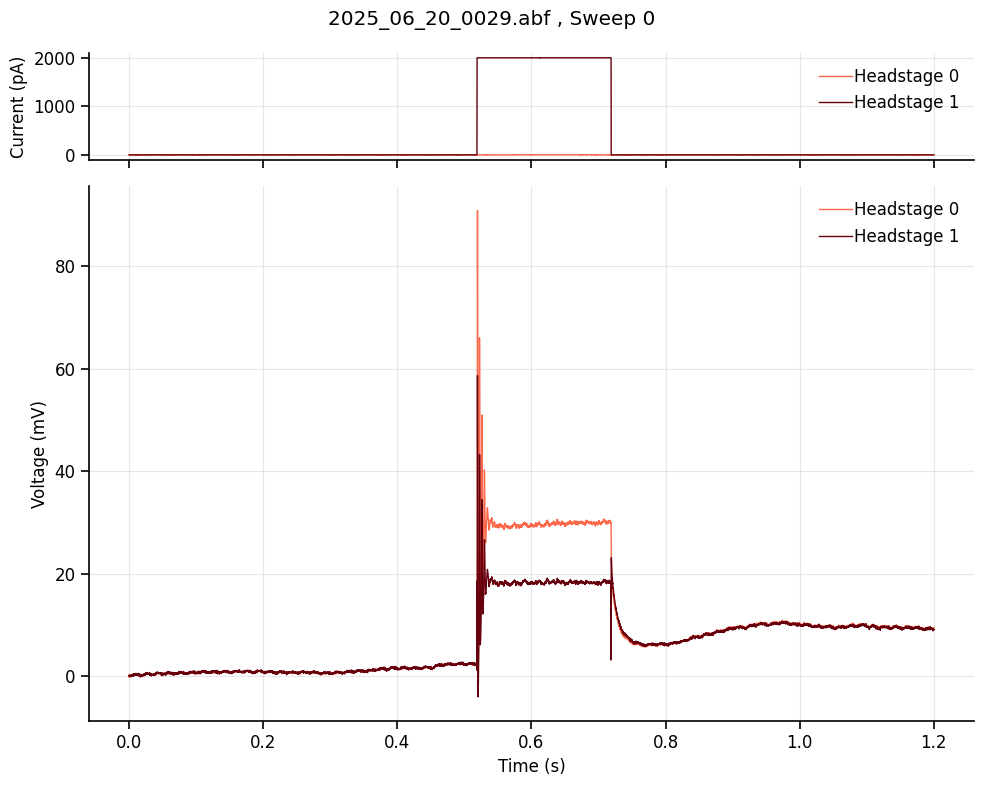

In [9]:
# Plot specific sweep with both headstages overlayed
sweep = 0
ax = traces.plot_multi_headstage(headstage=[0, 1], plot_current=True, plot_voltage=True, sweep=sweep, overlay_headstages=True, height_ratios=[1,5])
plt.show()

### Crop trace around the stimulus

In [31]:
# Choose a sweep with a positive current step to detect the step time
sweep = 0

if sweep > traces.num_sweeps-1:
    raise ValueError("Sweep number is too high!")

step_start = traces.get_step_events(headstage=1, threshold=5, channel='current', edge='rising', polarity='positive', time_units=time_units, sweep=sweep)
step_end = traces.get_step_events(headstage=1, threshold=5, channel='current', edge='falling', polarity='positive', time_units=time_units, sweep=sweep)
print(f"Step start: {step_start}")
print(f"Step end: {step_end}")

if len(step_start) == 0 or len(step_end) == 0:
    raise ValueError("No current step found! Make sure you got the right sweep!")

traces_during_stim = traces.crop(timepoint=step_start[0], timepoint_2=step_end[0], time_units=time_units, preserve_metadata=False)

Step start: [518.7]
Step end: [718.8]


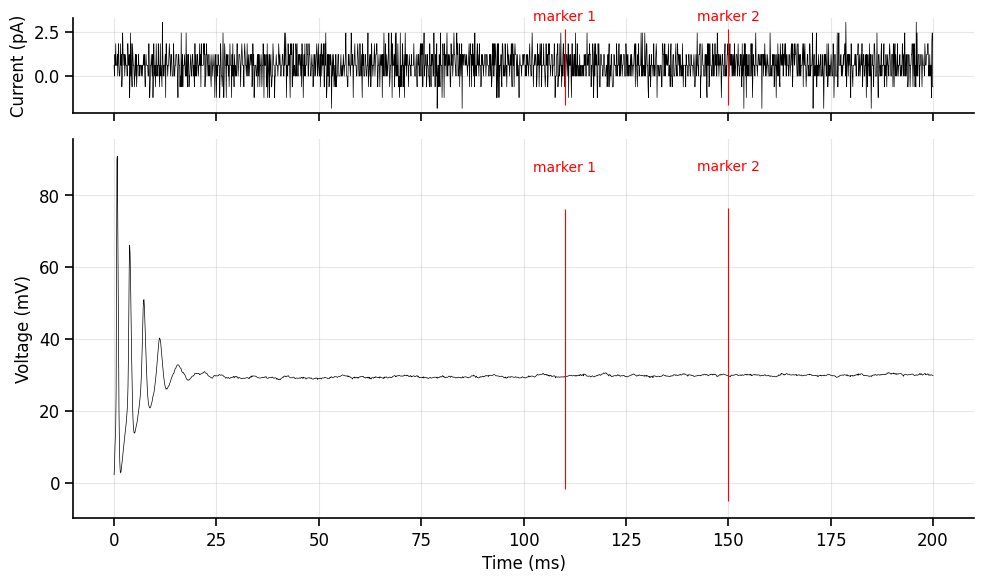

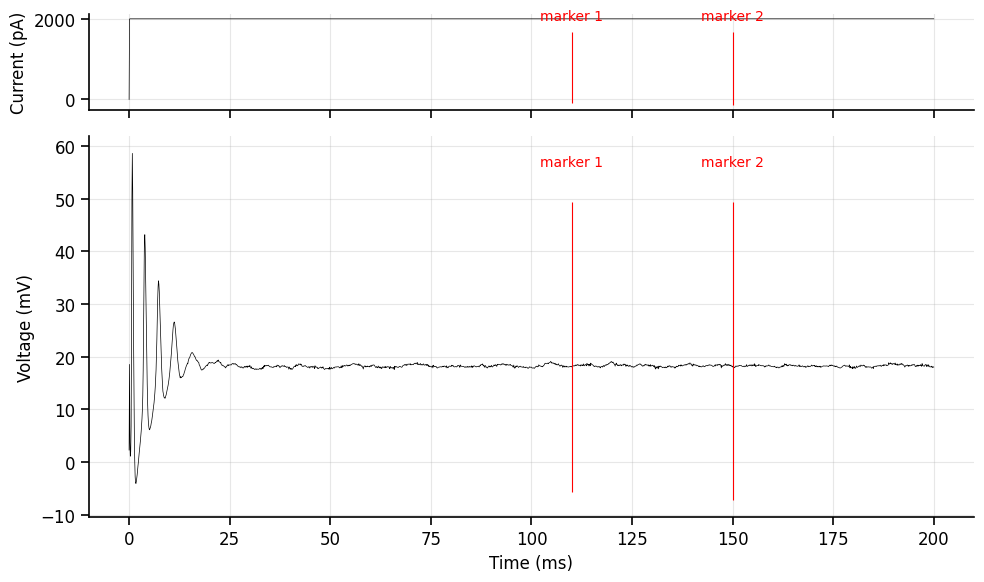

In [32]:
marker1 = 110
marker2 = 150
%matplotlib inline
traces_during_stim.plot_multi_headstage(headstage=0, plot_current=True, plot_voltage=True, height_ratios=[1, 4], time_units=time_units, marker_1=marker1, marker_2=marker2)
traces_during_stim.plot_multi_headstage(headstage=1, plot_current=True, plot_voltage=True, height_ratios=[1, 4], time_units=time_units, marker_1=marker1, marker_2=marker2)
plt.show()

### Measure the steady-state voltage in both channels

In [12]:
# Get measurements from headstage 1
current_vals1, voltage_vals1 = traces_during_stim.get_measurements_multi_headstage(start_time=marker1, end_time=marker2, headstage=0, time_units=time_units, measurement_type='mean')
current_vals2, voltage_vals2 = traces_during_stim.get_measurements_multi_headstage(start_time=marker1, end_time=marker2, headstage=1, time_units=time_units, measurement_type='mean')

Cell resistance (soma): 0.01 MOhm
Cell resistance (dendrite): 0.01 MOhm


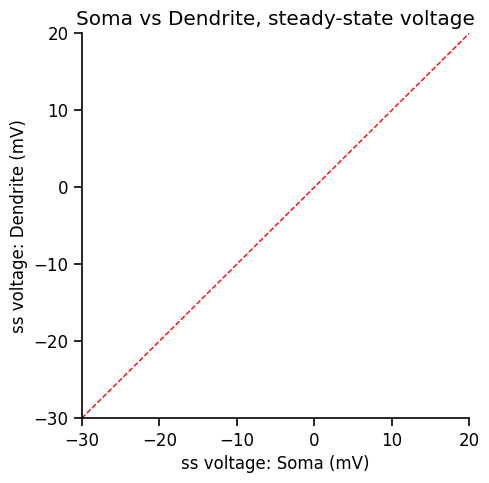

In [13]:
cell_resistance_soma = voltage_vals1[0] / current_vals2[0]
cell_resistance_dend = voltage_vals2[0] / current_vals2[0]

print(f'Cell resistance (soma): {cell_resistance_soma:.2f} MOhm')
print(f'Cell resistance (dendrite): {cell_resistance_dend:.2f} MOhm')

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.scatter(voltage_vals1, voltage_vals2, color='k', marker='o', s=50, zorder=10)
ax.plot([-30,20], [-30,20], color='r', lw=1, zorder=1, linestyle='--')
ax.set_xlabel('ss voltage: Soma (mV)')
ax.set_ylabel('ss voltage: Dendrite (mV)')
ax.set_ylim(-30,20)
ax.set_xlim(-30,20)
ax.set_title('Soma vs Dendrite, steady-state voltage')
plt.show()


## 3. Measure spike properties and firing rate

In [47]:
spike_results = traces_during_stim.analyze_action_potentials(min_spike_amplitude=10.0, 
                                                         max_width=10.0, 
                                                         min_ISI=1.0, 
                                                         headstage=0, 
                                                         sweep=None, # None means all sweeps
                                                         return_dict=True)

spike_results[0]

{'spike_times': array([2.5, 4.9, 5.9, 9.6]),
 'threshold_voltages': array([11.615 , 13.8489, 19.0125, 24.4141]),
 'peak_voltages': array([66.0095, 50.9216, 50.9216, 40.2466]),
 'spike_amplitudes': array([54.3945, 37.0728, 31.9092, 15.8325]),
 'spike_widths': array([1.8, 3. , 2. , 2.3]),
 'peak_times': array([ 3.8,  7.3,  7.3, 11.1])}

In [48]:
spike_results2 = traces_during_stim.analyze_action_potentials(min_spike_amplitude=10.0, 
                                                         max_width=10.0, 
                                                         min_ISI=1.0, 
                                                         headstage=1, 
                                                         sweep=None, # None means all sweeps
                                                         return_dict=True)

spike_results2[0]

{'spike_times': array([0.2, 2.6, 5.6, 6.6, 9.6]),
 'threshold_voltages': array([ 3.7842,  2.4109,  7.7209, 15.7776, 14.1907]),
 'peak_voltages': array([58.6243, 43.1824, 34.4238, 34.4238, 26.6113]),
 'spike_amplitudes': array([54.8401, 40.7715, 26.7029, 18.6462, 12.4207]),
 'spike_widths': array([0.9, 1.8, 2.4, 1.2, 2.4]),
 'peak_times': array([ 0.8,  3.9,  7.3,  7.3, 11.2])}

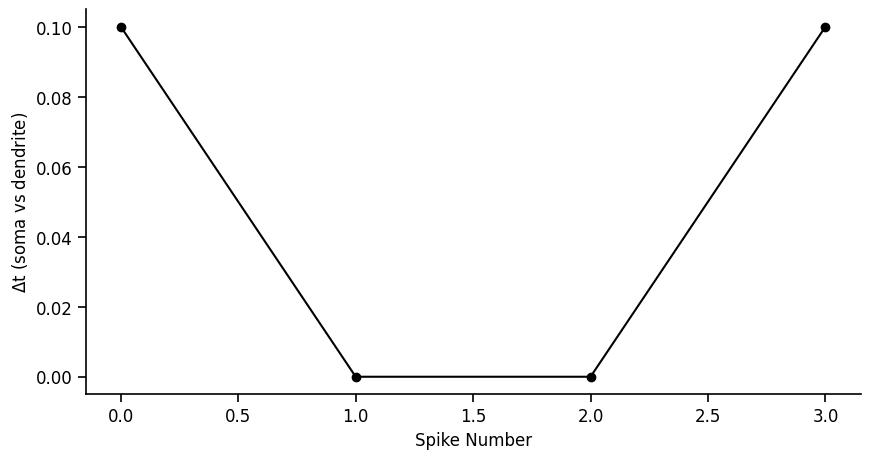

In [59]:
sweep = 0
soma_spike_times = spike_results[sweep]['peak_times'] 
dend_spike_times = spike_results2[sweep]['peak_times'][1:] #first spike is stim artifact, so we remove it

delta_time = dend_spike_times - soma_spike_times

fig, ax = plt.subplots(1,1,figsize=(10,5))
ax.plot(delta_time, '-o', color='black')
ax.set_xlabel('Spike Number')
ax.set_ylabel('$\Delta$t (soma vs dendrite)')
plt.show()

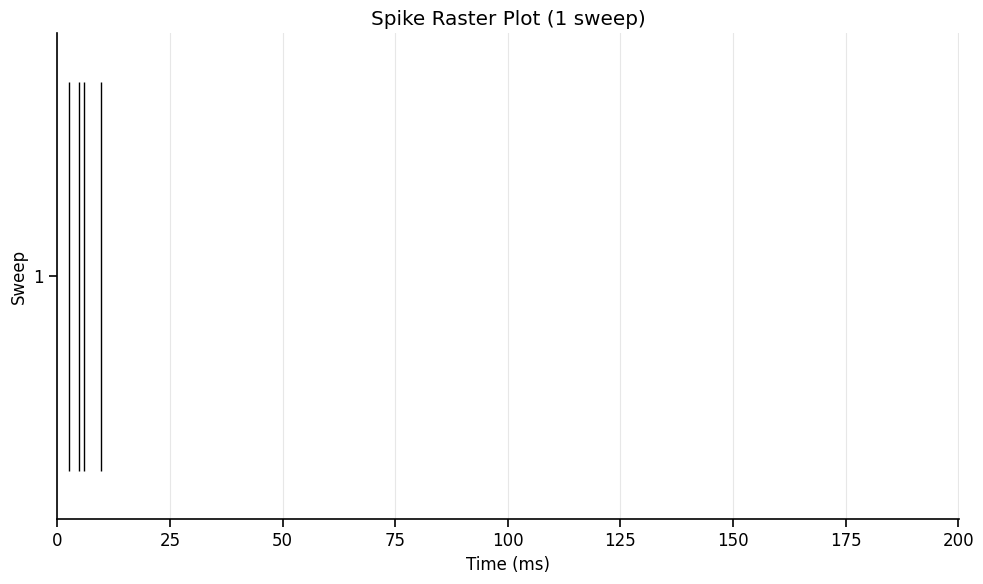

In [15]:
fig, ax = plot_spike_raster_from_trace(traces_during_stim, min_spike_amplitude=10)

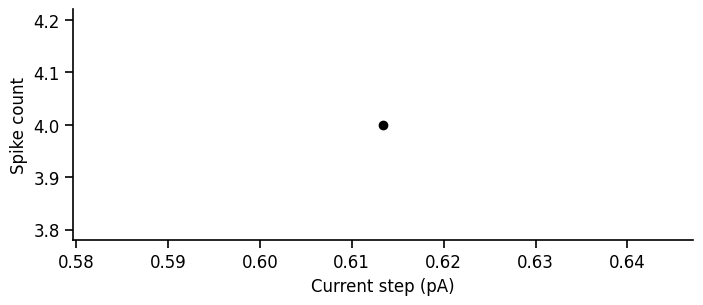

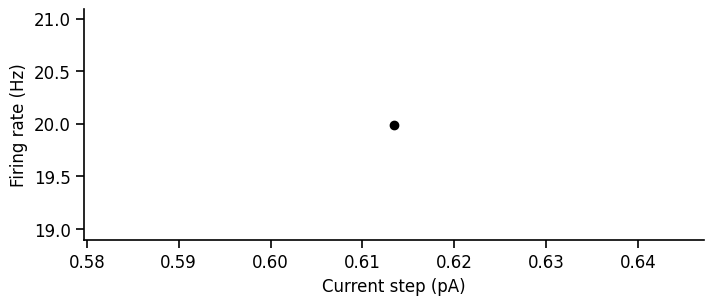

In [16]:
current_steps = current_vals1 # Make sure you're using the right current_vals!

spike_counts, stats = get_spike_counts(spike_results, return_stats=True)

fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(current_steps, spike_counts, '-o', color='black')
ax.set_xlabel(f'Current step ({traces.current_unit})')
ax.set_ylabel('Spike count')
# ax.set_ylim(bottom=-1)
plt.show()

total_time_s = traces_during_stim.total_time
firing_rate = spike_counts / total_time_s
fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(current_steps, firing_rate, '-o', color='black')
ax.set_xlabel(f'Current step ({traces.current_unit})')
ax.set_ylabel('Firing rate (Hz)')
# ax.set_ylim(bottom=-2)
plt.show()



Spike Property Summary:
--------------------------------------------------
Total spikes analyzed: 4

Peak Voltages (mV):
  Mean ± SD: 52.0 ± 9.2
  Range: [40.2, 66.0]

Spike Amplitudes (mV):
  Mean ± SD: 34.8 ± 13.8
  Range: [15.8, 54.4]

Spike Widths (ms):
  Mean ± SD: 2.28 ± 0.45
  Range: [1.80, 3.00]


(<Figure size 1200x400 with 3 Axes>,
 array([<AxesSubplot: title={'center': 'Peak Voltages'}, xlabel='Peak Voltages (mV)', ylabel='Count'>,
        <AxesSubplot: title={'center': 'Spike Amplitudes'}, xlabel='Spike Amplitudes (mV)', ylabel='Count'>,
        <AxesSubplot: title={'center': 'Spike Widths'}, xlabel='Spike Widths (ms)', ylabel='Count'>],
       dtype=object),
 {'peak_voltages': {'mean': 52.02484130859375,
   'std': 9.17514056859286,
   'min': 40.24658203125,
   'max': 66.009521484375,
   'n': 4},
  'spike_amplitudes': {'mean': 34.80224609375,
   'std': 13.758935300900175,
   'min': 15.83251953125,
   'max': 54.39453125,
   'n': 4},
  'spike_widths': {'mean': 2.2750000000000004,
   'std': 0.4548351349665062,
   'min': 1.8000000000000003,
   'max': 3.0,
   'n': 4}})

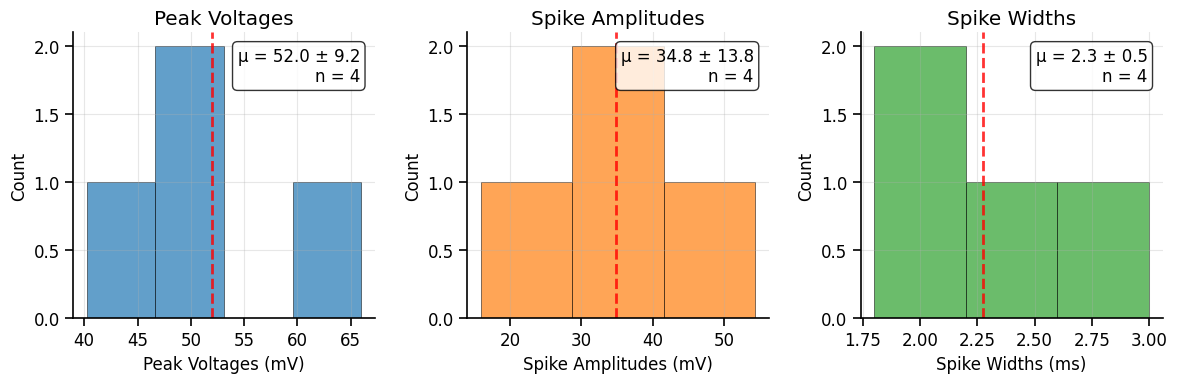

In [17]:
plot_spike_histograms(spike_results)